# Ответы на все вопросы

In [365]:
import pandas as pd
import matplotlib.pyplot as plt
import re, pyreadstat
from scipy import stats
from sklearn.linear_model import LinearRegression
import numpy as np

## Подготовка выборки

In [366]:
data, meta = pyreadstat.read_sav('data.sav', apply_value_formats = True)

In [367]:
color_print = lambda x, color = 'green': print("\u001B[32m"+x+"\u001B[0m") if color == 'green' else print("\033[91m"+x+"\u001B[0m")

In [368]:
map_columns = meta.column_names_to_labels
# xi2: Из какой республики СССР?
# xj10: Сколько денег в течение последних 30 дней Вы получили по основному месту работы после вычета налогов 
# и отчислений? Если все или часть денег Вы получили в иностранной валюте, переведите все в рубли и назовите 
# общую сумму
# 'xj14': 'В настоящее время Ваше предприятие осталось должно Вам какие-то деньги, которые по разным причинам не выплатило вовремя?''xj14': 'В настоящее время Ваше предприятие осталось должно Вам какие-то деньги, которые по разным причинам не выплатило вовремя?'
# 'xj18.2': 'В течение последних 12 месяцев Вам уменьшали зарплату или сокращали часы работы не по Вашему желанию?'
# 'xj21.3' 'Является ли производство, на котором Вы работаете, вредным или опасным, т.е. дающим Вам право на досрочное назначение трудовой пенсии, на дополнительные выплаты или льготы?','Является ли производство, на котором Вы работаете, вредным или опасным, т.е. дающим Вам право на досрочное назначение трудовой пенсии, на дополнительные выплаты или льготы?',

In [369]:
df = pd.DataFrame()
df['is_migrant'] = data['xi2'].astype('object')
df['region'] = data['region'].astype('object')
df['self_emp'] = data['xj26'].astype('object')
df['age'] = data['x_age'].astype("int8")
bins = [15, 30, 45, 60, 100]
labels = ['с 15 до 30', 'с 30 до 45', 'с 45 до 60', '60+']
df['age_group'] = pd.cut(df['age'], labels = labels, bins = bins)
df['leg_emp'] = data['xj11.1'].astype('object')
df['wage'] = data['xj10']
df['wage'] = pd.to_numeric(df['wage'], downcast = "float", errors = "coerce")
bins = np.array([0, 10, 20, 30, 40, 100]) * 1000
labels = [f"{i*10}-{10*(i+1)}" for i in range(4)] + ["40+"]
df['income_interval'] = pd.cut(df['wage'], bins = bins, labels = labels)
for i in range(1, 5):
    df[f'diploma_{i}'] = data[f'xj72.5c{"" if i == 1 else i}'].astype('object')
for i in (1, 2, 3, 4):
    df[f"uni_{i}"] = data[f"xj72.5b{'' if i == 1 else i}"].astype('object')
df

,is_migrant,region,self_emp,age,age_group,leg_emp,wage,income_interval,diploma_1,diploma_2,diploma_3,diploma_4,uni_1,uni_2,uni_3,uni_4
0,РОССИЯ,"Ленинградская область, Волосовский район",Нет,64,60+,Оформлены официально,20000.0,10-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,РОССИЯ,"Ленинградская область, Волосовский район",NaN,75,60+,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,РОССИЯ,"Ленинградская область, Волосовский район",NaN,73,60+,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,РОССИЯ,"Ленинградская область, Волосовский район",NaN,65,60+,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,РОССИЯ,"Ленинградская область, Волосовский район",Нет,51,с 45 до 60,Оформлены официально,18000.0,10-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12223,NaN,Московская область,NaN,48,с 45 до 60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12224,NaN,Московская область,Нет,70,60+,Оформлены официально,29000.0,20-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12225,РОССИЯ,Московская область,NaN,70,60+,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12226,РОССИЯ,Московская область,NaN,68,60+,NaN,NaN,NaN,Нет,NaN,NaN,NaN,5,NaN,NaN,NaN


## Обзор. Работа с данными

<b>Для проверяющего</b>
1. Я использую огромное количество датафреймов, в которых легко запутаться. Это сделано для того, чтобы не делать последующие выводы на перефильтрованных данных.
2. Возможно есть более лаконичные записи того, что я сделал 

<h5>Процент неофициально и официально трудоустроенных в различных возрастных группах</h5>
<p>
    С помощью аггрегирования разбил по возрастным группам респондентов и посмотрел процент работающих официально и нет
</p>

In [370]:
percentage = lambda x: round(x / x.sum() * 100, 2)
df_age_emp = pd.DataFrame()
df_age_emp = df[df['leg_emp'].isin(['Оформлены официально', 'Не оформлены официально'])].copy()
df_age_emp.groupby('age_group')['leg_emp'].value_counts().to_frame().groupby(level=0).apply(percentage)

leg_emp
age_group  leg_emp                         
с 15 до 30 Оформлены официально       91.47
           Не оформлены официально     8.53
с 30 до 45 Оформлены официально       93.14
           Не оформлены официально     6.86
с 45 до 60 Оформлены официально       92.03
           Не оформлены официально     7.97
60+        Оформлены официально       92.88
           Не оформлены официально     7.12

<h5>Проверим гипотезу: "Возраст не влияет на тип трудоустройства"</h5>
<img src="https://images.slideplayer.com/31/9626033/slides/slide_8.jpg" alter="картинка с хи-квадратом" width=300>

In [371]:
# Нулевая гипотеза: Возраст не влияет на тип трудоустройства
crosstab_age = pd.crosstab(df_age_emp['age_group'], df_age_emp['leg_emp'])
crosstab_age

leg_emp,Не оформлены официально,Оформлены официально
age_group,,
с 15 до 30,69,740
с 30 до 45,133,1805
с 45 до 60,120,1386
60+,28,365


In [372]:
# Начнем с расчета хи-квадрат по выборке
chi_val, p, f_dim, exp = stats.chi2_contingency(crosstab_age.values)
color_print(f"{round(chi_val, 2)} полученная величина chi-square")
# Посчитаем критическое значение при статистической важности 0.05 и количестве признаков f_dim = (2-1)*(4-1)=3
critical_value = stats.chi2.ppf(q = 1-0.05, df = f_dim)
color_print(f"{round(critical_value, 2)} - критическое значение chi-square", 'red')

2.91 полученная величина chi-square
7.81 - критическое значение chi-square


Таким образом, мы получили, что расчитанная величина хи-квадрат меньше максимально возможной, поэтому мы принимаем
гипотезу независимости на уровне значимости 0.05

<h5>Проверим гипотезу: "Наличие высшего образования не влияет на величину заработной платы"</h5>

In [373]:
# Нулевая гипотеза: Наличие высшего образования не влияет на величину заработной платы
df_wage = df[np.abs(df.wage - df.wage.mean()) <= (3 * df.wage.std())]
df_list = [df_wage['diploma_1'], df_wage['diploma_2'], df_wage['diploma_3'], df_wage['diploma_4']]
crosstab_wage = pd.crosstab(pd.concat(df_list), df_wage['income_interval'])
crosstab_wage.drop('НЕТ ОТВЕТА', axis = 0, inplace = True)
crosstab_wage

income_interval,0-10,10-20,20-30,30-40,40+
row_0,,,,,
Да,86,417,453,316,449
Нет,9,48,40,27,40


In [374]:
# Начнем с расчета хи-квадрат по выборке
chi_val, p, f_dim, exp = stats.chi2_contingency(crosstab_wage.values)
color_print(f"{round(chi_val, 2)} полученная величина chi-square")
# Посчитаем критическое значение при статистической важности 0.05 и количестве признаков f_dim = (2-1)*(5-1)=4
critical_value = stats.chi2.ppf(q = 1-0.05, df = f_dim)
color_print(f"{round(critical_value, 2)} - критическое значение chi-square", 'red')

2.29 полученная величина chi-square
9.49 - критическое значение chi-square


Таким образом, мы принимаем нулевую гипотезу о независимости двух распределений (наличие высшего образования не 
влияет на заработную плату) 
<br>
В конце файла есть небольшая регрессия количества оконченных лет в высшем учебном заведении с уровнем зп - зависимость оказалась незначительной

<h5>Проверим гипотезу: "Образование не влияет на тип трудойстройства"</h5>

In [375]:
# Создадим таблицу (Строки - количество с высшим образованием и без него)
# Нулевая гипотеза - Образование не влияет на тип трудойстройства
df_edu_emp = df_age_emp.copy()
df_list = [df_edu_emp['diploma_1'], df_edu_emp['diploma_2'], df_edu_emp['diploma_3'], df_edu_emp['diploma_4']]
crosstab_edu = pd.crosstab(pd.concat(df_list), df_edu_emp['leg_emp'])
crosstab_edu.drop('НЕТ ОТВЕТА', inplace = True)
crosstab_edu

leg_emp,Не оформлены официально,Оформлены официально
row_0,,
Да,57,1777
Нет,14,140


In [376]:
chi_val, p, f_dim, exp = stats.chi2_contingency(crosstab_edu.values)
color_print(f"{round(chi_val, 2)} полученная величина chi-square")
# Посчитаем критическое значение при статистической важности 0.05 и количестве признаков f_dim = (2-1)*(2-1) = 1
critical_value = stats.chi2.ppf(q = 1-0.05, df = f_dim)
color_print(f"{round(critical_value, 2)} - критическое значение chi-square", 'red')

13.08 полученная величина chi-square
3.84 - критическое значение chi-square


Таким образом, мы получили, что расчитанная величина хи-квадрат больше максимально возможной, поэтому мы отвергаем 
нулевую гипотезу на уровне значимости 0.05 и утверждаем, что величины зависят друг от друга

<h5>Средняя заработная плата среди официально и неофициально оформленных</h5>

In [377]:
# В целом зп среди всех
df_wage_emp = df_age_emp.copy()
df_wage_emp = df_wage_emp[np.abs(df_wage_emp.wage - df_wage_emp.wage.mean()) <= (3 * df_wage_emp.wage.std())]
df_wage_emp.groupby("leg_emp")['wage'].mean().round().to_frame()

,wage
leg_emp,
Не оформлены официально,21817.0
Оформлены официально,28124.0


In [378]:
# Общее количество мигрантов, немигрантов работающих официально и нет
df_migrant = df_age_emp.copy()
df_migrant['is_migrant'] = df_migrant['is_migrant'].dropna() == 'РОССИЯ'
df_migrant.groupby('is_migrant')['leg_emp'].value_counts().to_frame()

leg_emp
is_migrant leg_emp                         
False      Оформлены официально         291
           Не оформлены официально       38
True       Оформлены официально        1550
           Не оформлены официально      128

In [379]:
# Средняя зп среди мигрантов и местных
df_mi_wage = df_migrant.copy()
df_mi_wage = df_mi_wage[np.abs(df_mi_wage.wage - df_mi_wage.wage.mean()) <= (3 * df_mi_wage.wage.std())]
df_mi_wage.groupby(['is_migrant', 'leg_emp'])['wage'].mean().round().to_frame()

wage
is_migrant leg_emp                         
False      Не оформлены официально  20584.0
           Оформлены официально     31459.0
True       Не оформлены официально  22256.0
           Оформлены официально     27490.0

<h5>Статистический тест: Существует ли зависимость признака (мигрант или нет) с типом оформления?</h5>

In [380]:
# Нулевая гипотеза - признак (мигрант или нет) не влияет на тип оформления на работе
crosstab_migrant = pd.crosstab(df_migrant['is_migrant'], df_migrant['leg_emp'])
crosstab_migrant

leg_emp,Не оформлены официально,Оформлены официально
is_migrant,,
False,38,291
True,128,1550


In [381]:
# Расчитанная величина хи-квадрат
chi_val, p, f_dim, exp = stats.chi2_contingency(crosstab_migrant.values)
color_print(f"{round(chi_val, 2)} полученная величина chi-square")
# Посчитаем критическое значение при статистической важности 0.05 и количестве признаков f_dim = (2-1)*(2-1)=1
critical_value = stats.chi2.ppf(q = 1-0.05, df = f_dim)
color_print(f"{round(critical_value, 2)} - критическое значение chi-square", 'red')

5.07 полученная величина chi-square
3.84 - критическое значение chi-square


Таким образом, мы получили, что расчитанная величина хи-квадрат больше максимально возможной, поэтому мы отвергаем
гипотезу независимости на уровне значимости 0.05 и утверждаем, что зависимость существует

<h5>Статистический тест: Не существует зависимость между величиной заработной платы и типом оформления</h5>

In [382]:
# Нулевая гипотеза - Не существует зависимость между величиной заработной платы и типом оформления
crosstab_data = pd.crosstab(df_wage_emp['leg_emp'], df_wage_emp['income_interval'])
crosstab_data

income_interval,0-10,10-20,20-30,30-40,40+
leg_emp,,,,,
Не оформлены официально,68,124,79,36,21
Оформлены официально,265,1352,1083,612,672


In [383]:
chi_val, p, f_dim, exp = stats.chi2_contingency(crosstab_data.values)
color_print(f"{round(chi_val, 2)} полученная величина chi-square")
# Посчитаем критическое значение при статистической важности 0.05 и количестве признаков (10-1)*(2-1)=9
critical_value = stats.chi2.ppf(q = 1-0.05, df = f_dim)
color_print(f"{round(critical_value, 2)} - критическое значение chi-square", 'red')

104.73 полученная величина chi-square
9.49 - критическое значение chi-square


Таким образом, так как полученная величина хи-квадрат больше критической величины мы отвергаем нулевую гипотезу
и принимаем гипотезу о зависимости

<h5>Сравнение самозанятых и наемных рабочих по официальности трудоустройства</h5>

In [384]:
# xj26 - А Вы лично являетесь владельцем или совладельцем предприятия, на котором Вы работаете?
# xj29 - Как Вы считаете, на этой работе Вы занимаетесь предпринимательской деятельностью?

In [385]:
df_self_emp = df_age_emp.copy()
df_self_emp = df_self_emp[df_self_emp['self_emp'].isin(['Да', 'Нет'])]

In [386]:
# Процент официально, неофициально оформленных среди самозанятых
percent = lambda x: round(100 * x / float(x.sum()), 2)
df_self_emp.groupby('self_emp')['leg_emp'].value_counts().to_frame().groupby(level=0).apply(percent)

leg_emp
self_emp leg_emp                         
Да       Оформлены официально       93.08
         Не оформлены официально     6.92
Нет      Оформлены официально       92.45
         Не оформлены официально     7.55

<h5>Соотношение по типам трудоустройства по регионам</h5>

In [387]:
groupby_df_reg = df_age_emp.groupby('region')['leg_emp'].value_counts().to_frame()
groupby_df_reg['percentage'] = groupby_df_reg.groupby(['region'])['leg_emp'].apply(percent)
groupby_df_reg

leg_emp  \
region                                           leg_emp                            
Алтайский край, Бийск и Бийский район            Оформлены официально          91   
                                                 Не оформлены официально       11   
Алтайский край, Курьинский район                 Оформлены официально          70   
Амурская область, Тамбовский район               Оформлены официально          75   
Владивосток                                      Оформлены официально         130   
...                                                                           ...   
Удмуртская Республика, Глазов и Глазовский район Не оформлены официально        7   
Челябинск                                        Оформлены официально         104   
                                                 Не оформлены официально        9   
Челябинская область, Красноармейский район       Оформлены официально         103   
                                                 Не оформлены официально       11   

                                                                          percentage  
region                                           leg_emp                              
Алтайский край, Бийск и Бийский район            Оформлены официально          89.22  
                                                 Не оформлены официально       10.78  
Алтайский край, Курьинский район                 Оформлены официально         100.00  
Амурская область, Тамбовский район               Оформлены официально         100.00  
Владивосток                                      Оформлены официально          87.25  
...                                                                              ...  
Удмуртская Республика, Глазов и Глазовский район Не оформлены официально        5.60  
Челябинск                                        Оформлены официально          92.04  
                                                 Не оформлены официально        7.96  
Челябинская область, Красноармейский район       Оформлены официально          90.35  
                                                 Не оформлены официально        9.65  

[73 rows x 2 columns]

## Различные графики

In [388]:
# Создаем новый темп датафрейм df_graph для построения регресии величины заработной платы по количеству лет высшего
# образования
df_graph = pd.DataFrame()
df_graph['wage'] = df['wage']
df_graph['wage'] = df_graph[np.abs(df_graph.wage - df_graph.wage.mean()) <= (3 * df_graph.wage.std())]
df_graph.dropna(inplace = True)
df_graph['uni'] = df['uni_1']
df_graph = df_graph[~df_graph['uni'].isin(['НЕТ ОТВЕТА', 'ЗАТРУДНЯЮСЬ ОТВЕТИТЬ'])]
df_graph = df_graph[~df_graph['uni'].isnull()]

In [389]:
# Построим линейную регрессию
x_values = df_graph['uni'].to_numpy().reshape(-1, 1)
y_values = df_graph['wage'].to_numpy().reshape(-1, 1)
reg = LinearRegression().fit(x_values, y_values)
k = reg.coef_[0][0]
reg.intercept_[0]
X = np.arange(0, 10, 0.1)
Y = X * k + b

Линейная регрессия - wage=1010.94*uni_years+27653.88


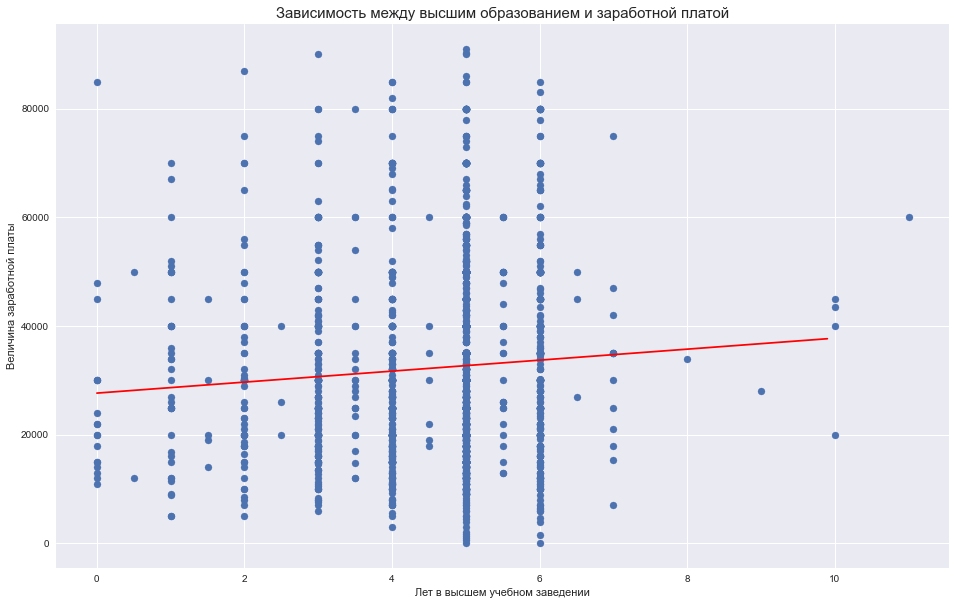

In [390]:
plt.style.use('seaborn')
fig = plt.figure(figsize = (16, 10))
ax1 = fig.add_subplot(111)
ax1.scatter(df_graph['uni'], df_graph['wage'])
ax1.plot(X, Y,'red')
ax1.set_title('Зависимость между высшим образованием и заработной платой', fontsize = 15)
ax1.set_xlabel('Лет в высшем учебном заведении')
ax1.set_ylabel('Величина заработной платы')
color_print(f"Линейная регрессия - wage={round(k, 2)}*uni_years+{round(b, 2)}")
# Как видим высшее образование почти не влияет на величину заработной платы (как было доказано статистическим тестом)

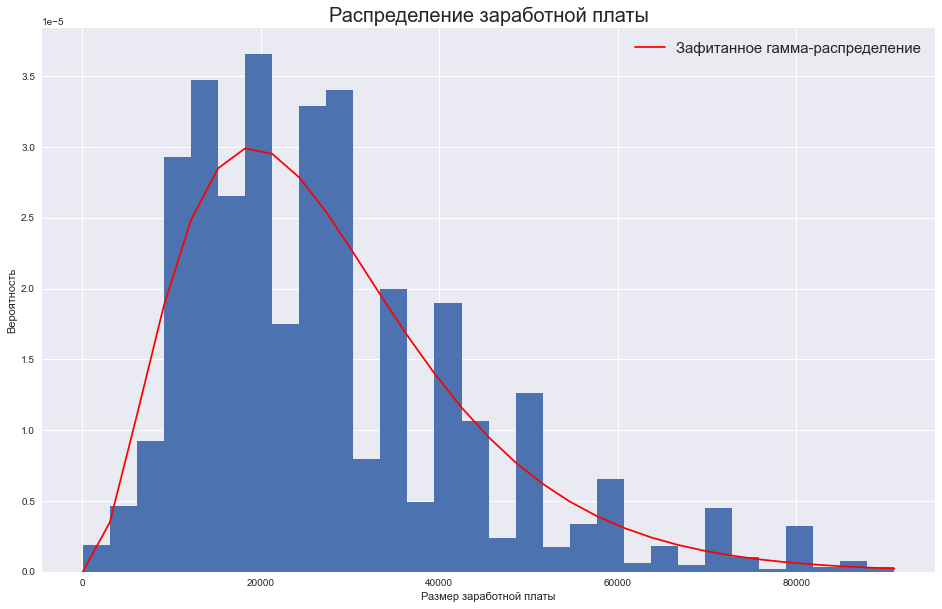

In [391]:
# В целом по выборке
from scipy import stats
plt.style.use('seaborn')
fig = plt.figure(figsize = (16, 10))
ax1 = fig.add_subplot(111)
ax1.set_title('Распределение заработной платы', fontsize = 20)
ax1.set_xlabel('Размер заработной платы')
ax1.set_ylabel('Вероятность')
params = stats.gamma.fit(df_wage_emp.wage, floc = 0)
_, bins, _ = ax1.hist(df_wage_emp.wage, bins = 30, density = True)
norm_fit_line = stats.gamma.pdf(bins, *params)
ax1.plot(bins, norm_fit_line, 'red')
ax1.legend(['Зафитанное гамма-распределение'], fontsize = 15)